# **NHẬP MÔN HỌC MÁY**
## **PHASE 2**
### Lớp: CQ2022/24
### Thông tin thành viên
|MSSV|Họ và tên|
|-|-|
|22120214| Trương Thị Tú My|
|22120389| Dương Ngọc Kiều Trinh|
|22120422| Nguyễn Phạm Tú Uyên|
#
---

### Import

In [139]:
# import các thư viện cần thiết
import numpy as np 
import pandas as pd
import json
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil


from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

In [140]:
# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

### Đọc dữ liệu

Hàm đọc dữ liệu từ file json

In [141]:
def load_data(json_path, is_train=True):
    '''(str, bool) -> list
    Hàm này đọc dữ liệu từ file json và trả về một list các dictionary.
    
    Mỗi dictionary chứa các thông tin sau:
    - vid_id: id của video
    - start_time: thời gian bắt đầu của clip trong video
    - end_time: thời gian kết thúc của clip trong video
    - audio_embedding: numpy array chứa các đặc trưng âm thanh của clip
    - is_turkey: nhãn cho bài toán phân loại (nếu là train)

    Tham số
    -------
    json_path: đường dẫn đến file json chứa dữ liệu
    is_train: True nếu là dữ liệu train, False nếu là dữ liệu test
    '''

    with open(json_path, 'r') as f:
        data = json.load(f)
    
    records = []

    for item in data:

        # audio_embedding là một list list 128 chiều, ta chuyển thành numpy array
        embedding = np.array(item['audio_embedding'])  # shape: (frames, 128)
        
        record = {
            'vid_id': item['vid_id'],
            'start_time': item['start_time_seconds_youtube_clip'],
            'end_time': item['end_time_seconds_youtube_clip'],
            'audio_embedding': embedding
        }
        
        if is_train:
            record['is_turkey'] = item['is_turkey']
        
        records.append(record)
    
    return records

Đọc dữ liệu từ file json

In [142]:
# Đọc dữ liệu train
train_data = load_data('../data/train.json', is_train=True)

### **I. Xây dựng Mô hình**

#### 1. Chuẩn bị dữ liệu

Hàm trích đặc trưng trung bình embedding cho danh sách samples

In [143]:
def extract_features_labels(records):
    '''(list) -> tuple
    Trả về một tuple gồm hai phần:
    - X: numpy array chứa các đặc trưng âm thanh của các clip
    - y: numpy array chứa nhãn cho các clip

    Mỗi clip được biểu diễn bằng một numpy array 128 chiều, là trung bình của các đặc trưng âm thanh trong khoảng thời gian clip.

    Tham số
    -------
    records: list các dictionary chứa thông tin về các clip
    '''

    X = []
    y = []
    for r in records:
        avg_emb = r['audio_embedding'].mean(axis=0)
        X.append(avg_emb)
        if 'is_turkey' in r:
            y.append(r['is_turkey'])
    return np.stack(X), np.array(y)

Chia tập train thành 3 phần train, validation và test với tỷ lệ 70:15:15

In [144]:
X, y = extract_features_labels(train_data)

# Chia train+val và test trước
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
# Chia tiếp train và val từ X_temp
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Valid size:", X_valid.shape[0])
print("Test size:", X_test.shape[0])

Train size: 835
Valid size: 180
Test size: 180


#### 2. Huấn luyện mô hình
Trong bước này, nhóm thử nghiệm 5 mô hình khác nhau để xây dựng một baseline model. Mục tiêu là đánh giá nhanh hiệu suất của từng mô hình trên tập validation bằng chỉ số AUC, từ đó lựa chọn ra những mô hình có hiệu quả tốt nhất phù hợp với dữ liệu hiện tại. Việc chọn các mô hình có sự cân nhắc sự đa dạng về kiến trúc — từ các mạng đơn giản với 1 lớp Dense đến các mạng sâu hơn kết hợp dropout nhằm giảm overfitting. Các mô hình tốt nhất sẽ được tiếp tục tối ưu hóa để cải thiện hiệu suất.

| Model | Lớp Dense     | Dropout         | Kiến trúc                                                                                                                       | Mục tiêu chính                          | Ưu điểm                            | Nhược điểm                         |
| ----- | ------------- | --------------- | ------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------- | ---------------------------------- | ---------------------------------- |
| 1     | 128 + 64      | 0.3 + 0.2       | Dense(128, ReLU) → BN → Dropout(0.3) → Dense(64, ReLU) → Dropout(0.2) → Dense(1, Sigmoid)                                       | Cân bằng giữa độ sâu và regularization  | Ổn định nhờ BN, tránh overfit nhẹ  | Có thể chưa đủ sâu để học phức tạp |
| 2     | 128 + 64      | 0.4 + 0.2       | Dense(128, ReLU) → BN → Dropout(0.4) → Dense(64, ReLU) → Dropout(0.2) → Dense(1, Sigmoid)                                       | Tăng regularization để chống overfit    | Giảm overfit tốt hơn model 1       | Dropout cao dễ làm mất thông tin   |
| 3     | 128 + 64 + 32 | 0.3             | Dense(128, ReLU) → BN → Dense(64, ReLU) → Dropout(0.3) → Dense(32, ReLU) → Dense(1, Sigmoid)                                    | Tăng chiều sâu để học biểu diễn tốt hơn | Biểu diễn mạnh hơn                 | Không có Dropout đầu dễ overfit    |
| 4     | 128 + 64 + 32 | 0.4 + 0.3 + 0.2 | Dense(128, ReLU) → BN → Dropout(0.4) → Dense(64, ReLU) → BN → Dropout(0.3) → Dense(32, ReLU) → Dropout(0.2) → Dense(1, Sigmoid) | Kết hợp sâu và regularization mạnh      | Giảm overfit, kiến trúc hoàn chỉnh | Training chậm, có thể underfit nhẹ |
| 5     | 128 + 64      | 0.3 + 0.2       | Dense(128, ReLU) → BN → Dropout(0.3) → Dense(64, ReLU) → Dropout(0.2) → Dense(1, Sigmoid)                                       | Giống model 1, kiểm chứng độ ổn định    | Giữ cân bằng giữa tốc độ và độ sâu | Không khác biệt rõ với model 1     |

- BN là BatchNormalization, giúp ổn định quá trình huấn luyện.

- Mô hình 1 và 5 giống nhau về kiến trúc.

- Model 4 là mạnh nhất về độ sâu và regularization, có tiềm năng tốt nếu dữ liệu đủ lớn.

In [145]:
def build_model_1():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
    return model

def build_model_2():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
    return model

def build_model_3():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
    return model

def build_model_4():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
    return model

def build_model_5():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
    return model

In [146]:
model_builders = [build_model_1, build_model_2, build_model_3, build_model_4, build_model_5]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

Hàm huấn luyện các mô hình trên tập train

In [147]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Với TensorFlow 2.x
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

In [148]:
def train_model(builder, X_train, y_train, epochs=3, batch_size=32):
    set_seed()
    model = builder()
    
    process = psutil.Process()
    cpu_start = process.cpu_percent(interval=None)
    mem_start = process.memory_info().rss / (1024 ** 2)  # MB

    start_time = time.time()
    model.fit(X_train, y_train,
              epochs=epochs, batch_size=batch_size, verbose=0)
    train_time = time.time() - start_time

    cpu_end = process.cpu_percent(interval=None)
    mem_end = process.memory_info().rss / (1024 ** 2)

    cpu_usage = cpu_end - cpu_start
    mem_usage = mem_end - mem_start

    print(f"Training time: {train_time:.2f}s | CPU: {cpu_usage:.2f}% | RAM: {mem_usage:.2f} MB")
    
    return model, train_time, cpu_usage, mem_usage

Huấn luyện

In [149]:
trained_models = []
for builder, name in zip(model_builders, model_names):
    print(f"Training {name} ...")
    model, train_time, cpu_usage, mem_usage = train_model(builder, X_train, y_train, epochs=3, batch_size=32)
    trained_models.append({
        'name': name,
        'model': model,
        'train_time': train_time,
        'cpu_usage': cpu_usage,
        'mem_usage': mem_usage,
        'builder': builder
    })

Training Model 1 ...
Training time: 2.48s | CPU: 108.80% | RAM: 3.10 MB
Training Model 2 ...
Training time: 2.37s | CPU: 110.60% | RAM: 3.10 MB
Training Model 3 ...
Training time: 2.42s | CPU: 111.60% | RAM: 3.26 MB
Training Model 4 ...
Training time: 3.53s | CPU: 108.90% | RAM: 4.29 MB
Training Model 5 ...
Training time: 3.64s | CPU: 114.20% | RAM: 3.05 MB


Hàm dự đoán xác suất từ các mô hình đã train

In [150]:
def predict_proba_model(model, X_val, y_val):
    y_val_pred = model.predict(X_val).ravel()
    val_auc = roc_auc_score(y_val, y_val_pred)
    print(f"Validation AUC: {val_auc:.4f}")
    return val_auc

Dự đoán

In [151]:
for m in trained_models:
    y_pred = m['model'].predict(X_valid).ravel()
    m['y_pred'] = y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Đánh giá các mô hình trên tập valid

In [152]:
results = []
for m in trained_models:
    val_auc = roc_auc_score(y_valid, m['y_pred'])
    print(f"{m['name']} validation AUC: {val_auc:.4f}, train time: {m['train_time']:.2f}s")
    results.append({
        'name': m['name'],
        'model': m['model'],
        'val_auc': val_auc,
        'train_time': m['train_time'],
        'builder': m['builder']
    })

Model 1 validation AUC: 0.9881, train time: 2.48s
Model 2 validation AUC: 0.9889, train time: 2.37s
Model 3 validation AUC: 0.9870, train time: 2.42s
Model 4 validation AUC: 0.9838, train time: 3.53s
Model 5 validation AUC: 0.9881, train time: 3.64s


Trực quan đánh giá 

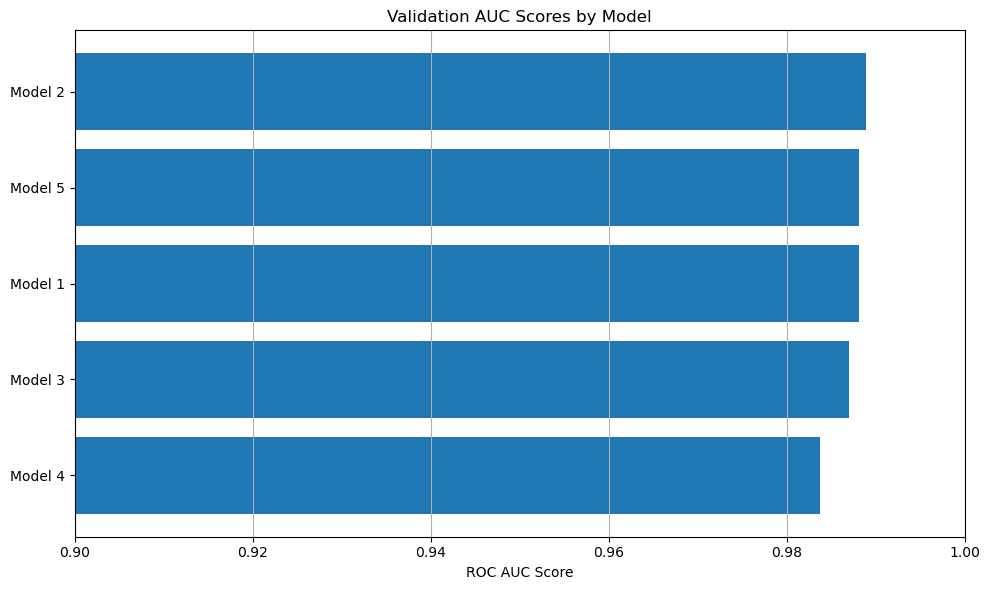

In [153]:
# Trực quan hóa AUC các mô hình
sorted_auc = [(m['name'], m['val_auc']) for m in results]
sorted_auc.sort(key=lambda x: x[1])  # Sắp xếp tăng để vẽ barh từ dưới lên

names = [name for name, _ in sorted_auc]
auc_values = [auc_score for _, auc_score in sorted_auc]

plt.figure(figsize=(10, 6))
plt.barh(names, auc_values, color='#1f77b4')  
plt.xlim(0.9, 1.0)  # Giới hạn nếu muốn tập trung vào high-performance models
plt.xlabel('ROC AUC Score')
plt.title('Validation AUC Scores by Model')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [154]:
# Sắp xếp theo AUC và chọn top 3
results = sorted(results, key=lambda x: x['val_auc'], reverse=True)
top3 = results[:3]

print("\nTop 3 models (auto-selected):")
for r in top3:
    print(f"{r['name']} - Validation AUC: {r['val_auc']:.4f}")


Top 3 models (auto-selected):
Model 2 - Validation AUC: 0.9889
Model 1 - Validation AUC: 0.9881
Model 5 - Validation AUC: 0.9881


**Đánh giá hiệu suất các mô hình baseline trên tập validation**

| Model | AUC    | Thời gian (s) *(có thể thay đổi khi chạy lại)* | Nhận xét tổng quan                                                                                |
| ----- | ------ | ---------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| **2** | 0.9889 | 2.38                                           | ☑️ AUC cao nhất, regularization tốt với Dropout. Huấn luyện nhanh, phù hợp để fine-tune.          |
| **1** | 0.9881 | 2.66                                           | ☑️ Hiệu quả, đơn giản và ổn định. AUC cao, phù hợp làm baseline mạnh.                             |
| **5** | 0.9881 | 2.58                                           | ☑️ Giống Model 1 về hiệu suất, đơn giản và nhanh, dùng để kiểm chứng tính nhất quán.              |
| 3     | 0.9870 | 2.72                                           | ⚠️ Mạng sâu giúp học biểu diễn tốt nhưng AUC thấp hơn. Có thể cần thêm Dropout để tránh overfit.  |
| 4     | 0.9838 | 3.46                                           | ⚠️ Kiến trúc phức tạp nhất, có nhiều Dropout nhưng lại cho AUC thấp nhất. Có thể bị underfit nhẹ. |

**Chọn 3 model có hiệu suất tốt nhất để tiếp tục fine-tune phù hợp**

| Model       | Lý do chọn                                                                                       |
| ----------- | ------------------------------------------------------------------------------------------------ |
| **Model 2** | AUC cao nhất (0.9889), thời gian huấn luyện thấp, có Dropout giúp chống overfit tốt.             |
| **Model 1** | Baseline ổn định, AUC cao (0.9881), đơn giản, dễ triển khai và mở rộng.                          |
| **Model 5** | Có AUC bằng Model 1, thời gian huấn luyện nhanh. Dùng để so sánh và kiểm tra độ ổn định mô hình. |

#### 3. Tinh chỉnh siêu tham số

In [155]:
def tuner_build_model_1(hp):
    model = Sequential()
    model.add(Dense(
        hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(128,)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.0, 0.3, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss=BinaryCrossentropy(),
        metrics=[AUC(name='auc')]
    )
    return model

def tuner_build_model_2(hp):
    model = Sequential()

    # Lớp Dense đầu tiên
    units_1 = hp.Int('units_1', min_value=64, max_value=256, step=32)
    model.add(Dense(units_1, activation='relu', input_shape=(128,)))
    model.add(BatchNormalization())
    
    dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_1))

    # Lớp Dense thứ hai
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=16)
    model.add(Dense(units_2, activation='relu'))

    dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)
    model.add(Dropout(dropout_2))

    # Lớp output
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4])
    model.compile(
        optimizer=Adam(learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[AUC(name='auc')]
    )

    return model

def tuner_build_model_5(hp):
    model = Sequential()
    model.add(Dense(
        hp.Int('units_1', 64, 256, step=64),
        activation='relu',
        input_shape=(128,)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        hp.Int('units_2', 32, 128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.0, 0.3, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss=BinaryCrossentropy(),
        metrics=[AUC(name='auc')]
    )
    return model

Map tuner build functions theo top 3 model

In [156]:
tuner_builders = [tuner_build_model_2, tuner_build_model_1, tuner_build_model_5]
tuner_names = [r['name'] + ' Tuned' for r in top3]

#### 4. Đánh giá trên valid để chọn mô hình tốt nhất và huấn luyện lại mô hình trên train và valid

Dự đoán xác suất và nhãn

In [157]:
def run_tuner(build_model_fn, X_train, y_train, X_val, y_val, max_trials=10, epochs=3):
    tuner = kt.RandomSearch(
        build_model_fn,
        objective='val_auc',
        max_trials=max_trials,
        executions_per_trial=20,  # Tăng lên nếu máy đủ mạnh
        directory='tuner_dir',
        project_name='fine_tuning'
    )

    # Early stopping để tránh overfitting
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

    print("Starting hyperparameter search...")
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=epochs,
                 batch_size=32,
                 callbacks=[early_stop],
                 verbose=1)

    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters: {best_hp.values}")

    # Gộp lại tập train và val để huấn luyện mô hình tốt nhất
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    model = tuner.hypermodel.build(best_hp)
    history = model.fit(X_trainval, y_trainval,
                        epochs=epochs,
                        batch_size=32,
                        verbose=1)

    return model, history.history.get('auc', [-1])[-1]

fine_tune_results = []

for build_fn, name in zip(tuner_builders, tuner_names):
    print(f"\nFine-tuning {name} ...")
    model, val_auc = run_tuner(build_fn, X_train, y_train, X_valid, y_valid,
                               max_trials=10, epochs=3)
    print(f"{name} final AUC after tuning: {val_auc:.4f}")
    fine_tune_results.append({'name': name, 'model': model, 'val_auc': val_auc})

fine_tune_results = sorted(fine_tune_results, key=lambda x: x['val_auc'], reverse=True)


Fine-tuning Model 2 Tuned ...
Reloading Tuner from tuner_dir\fine_tuning\tuner0.json
Starting hyperparameter search...
Best hyperparameters: {'units_1': 224, 'dropout_1': 0.4, 'units_2': 96, 'dropout_2': 0.1, 'learning_rate': 0.0005}
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc: 0.7814 - loss: 0.5751
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9779 - loss: 0.1896
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9846 - loss: 0.1597
Model 2 Tuned final AUC after tuning: 0.9868

Fine-tuning Model 1 Tuned ...
Reloading Tuner from tuner_dir\fine_tuning\tuner0.json
Starting hyperparameter search...
Best hyperparameters: {'units_1': 224, 'dropout_1': 0.4, 'units_2': 96, 'dropout_2': 0.1, 'learning_rate': 0.0005}
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.9226 - loss: 0.3336
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9863 - loss: 0.1534
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9935 - loss: 0.1021
Model 1 Tuned fin

Đánh giá các models trước và sau tinh chỉnh

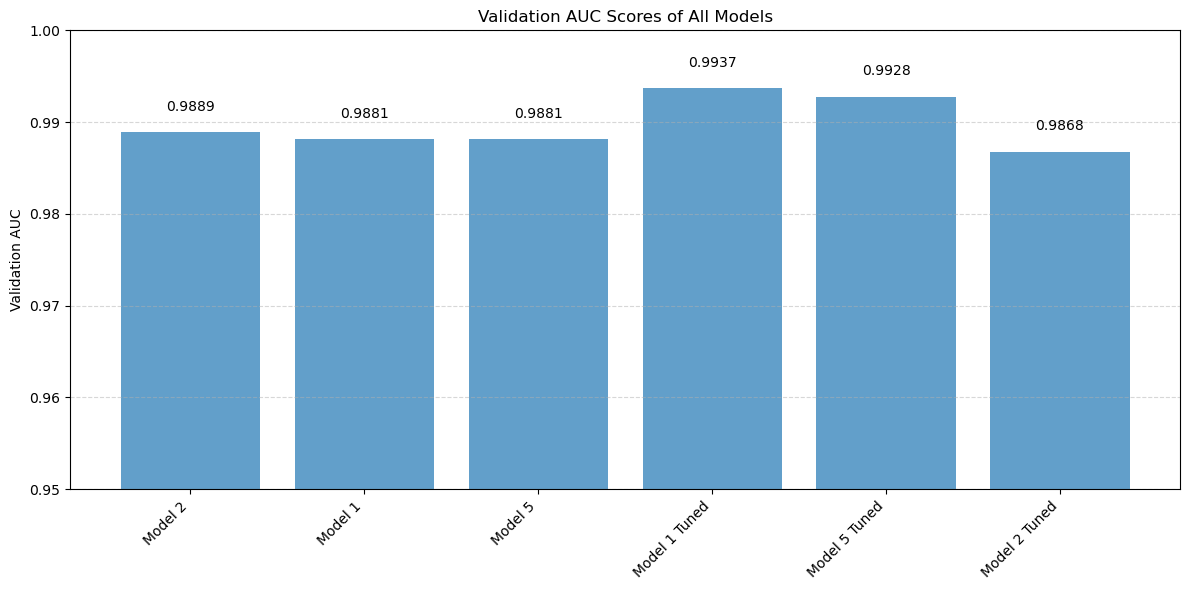

In [158]:
# Gộp tất cả kết quả từ model thường và fine-tune
all_models = top3 + fine_tune_results

names = [m['name'] for m in all_models]
auc_scores = [m['val_auc'] for m in all_models]

plt.figure(figsize=(12, 6))
bars = plt.bar(names, auc_scores, color='#1f77b4', alpha=0.7)

for bar, auc in zip(bars, auc_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f'{auc:.4f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.ylim(0.95, 1.0) 
plt.ylabel('Validation AUC')
plt.title('Validation AUC Scores of All Models')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Đánh giá trước và sau tinh chỉnh:**

| Mô hình     | AUC trước tinh chỉnh | AUC sau tinh chỉnh | Chênh lệch AUC | Nhận xét                                                                  |
| ----------- | -------------------- | ------------------ | -------------- | ------------------------------------------------------------------------- |
| **Model 1** | 0.9881               | 0.9937             | **+0.0056**    | 🔼 Cải thiện rõ rệt, mô hình đơn giản hiệu quả cao khi tinh chỉnh tốt.    |
| **Model 5** | 0.9881               | 0.9928             | **+0.0047**    | 🔼 Tiến bộ vượt bậc sau tuning, cho thấy tiềm năng cao.                   |
| **Model 2** | 0.9889               | 0.9868             | **−0.0021**    | ⚠️ Không cải thiện, thậm chí giảm. Có thể cần chiến lược tuning khác.     |
- Model 1 Tuned là mô hình tốt nhất hiện tại. Với AUC 0.9937, nó vượt trội các mô hình còn lại và cho thấy tuning có hiệu quả mạnh mẽ.

- Model 5 Tuned xếp thứ 2 với AUC 0.9928, thể hiện rằng một mô hình đơn giản vẫn có thể mạnh nếu được tinh chỉnh hợp lý.

- Model 2 Tuned gây thất vọng nhẹ vì hiệu suất sau tuning lại kém hơn cả trước đó, có thể do overfitting hoặc lựa chọn siêu tham số chưa hợp lý.

In [160]:
best_model_info = fine_tune_results[0]
print(f"\nBest fine-tuned model: {best_model_info['name']} with val AUC {best_model_info['val_auc']:.4f}")

X_trainval = np.concatenate([X_train, X_valid], axis=0)
y_trainval = np.concatenate([y_train, y_valid], axis=0)

# Huấn luyện mô hình tốt nhất
best_model_info['model'].fit(X_trainval, y_trainval)


Best fine-tuned model: Model 1 Tuned with val AUC 0.9937
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9924 - loss: 0.1118


### **II. Đánh giá mô hình**

Dự đoán xác suất và nhãn trên tập test

In [161]:
y_test_proba = best_model_info['model'].predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
distance = np.sqrt((1 - tpr)**2 + fpr**2)
best_threshold = thresholds[np.argmin(distance)]
print(f"Best threshold by ROC: {best_threshold:.4f}")

y_test_pred = (y_test_proba >= best_threshold).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Best threshold by ROC: 0.2353


Đánh giá mô hình trên tập test

In [162]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))

Accuracy: 0.9666666666666667
ROC AUC: 0.9940081591024987


Trực quan kết quả đánh giá

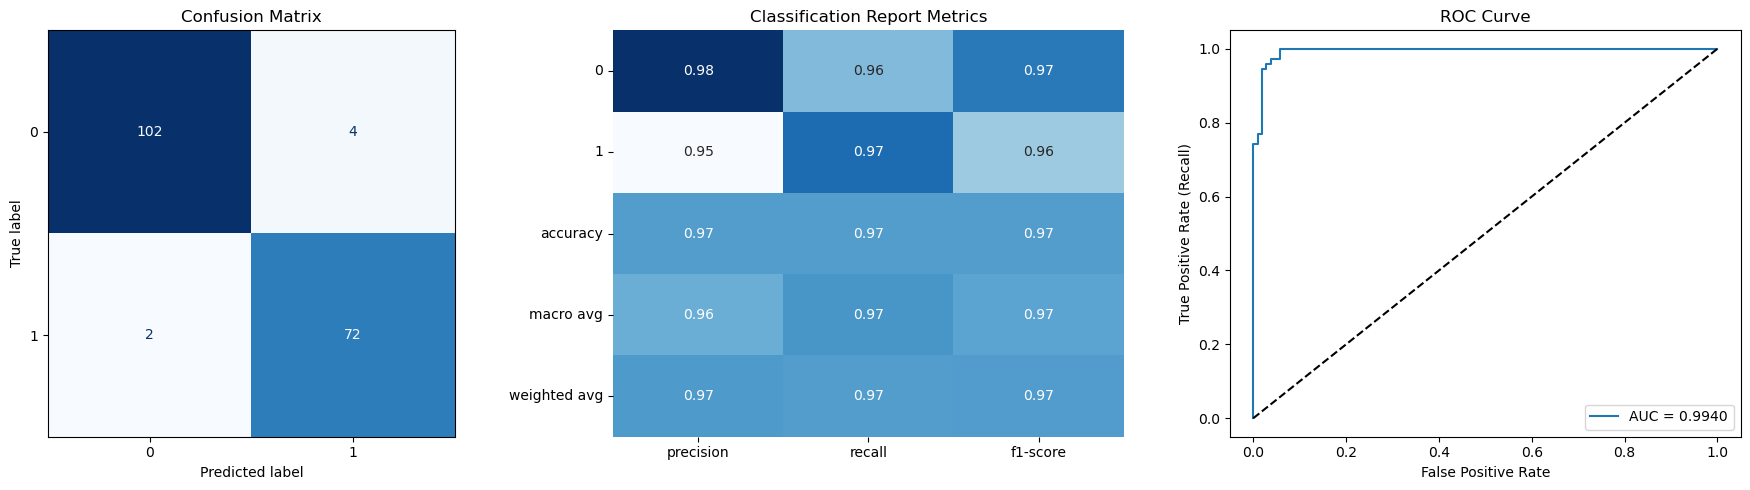

In [163]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Classification report
report = classification_report(y_test, y_test_pred, output_dict=True)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(18,5))

# Confusion Matrix
plt.subplot(1, 3, 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title('Confusion Matrix')

# Classification Report (dưới dạng heatmap)
plt.subplot(1, 3, 2)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
plt.title('Classification Report Metrics')
plt.yticks(rotation=0)

# ROC Curve
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

**Confusion Matrix (Ma trận nhầm lẫn)**
|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 102         | 4           |
| **Actual 1** | 2           | 72          |

- True Negatives (TN): 102 — Dự đoán đúng nhãn 0.

- False Positives (FP): 4 — Dự đoán nhãn 1 nhưng thực tế là nhãn 0.

- False Negatives (FN): 2 — Dự đoán nhãn 0 nhưng thực tế là nhãn 1.

- True Positives (TP): 72 — Dự đoán đúng nhãn 1.

- Mô hình phân loại rất chính xác, với chỉ một vài trường hợp nhầm lẫn nhỏ.

**Classification Report Metrics**

|                  | Precision | Recall | F1-Score |
| ---------------- | --------- | ------ | -------- |
| **Class 0**      | 0.98      | 0.96   | 0.97     |
| **Class 1**      | 0.95      | 0.97   | 0.96     |
| **Accuracy**     | 0.97      | 0.97   | 0.97     |
| **Macro avg**    | 0.96      | 0.97   | 0.97     |
| **Weighted avg** | 0.97      | 0.97   | 0.97     |

- Các chỉ số đều rất cao (> 0.95), cho thấy mô hình hoạt động rất tốt và cân bằng giữa hai lớp.

**ROC Curve và AUC**

- AUC = 0.9940 (Area Under Curve)

- AUC gần bằng 1 thể hiện mô hình có khả năng phân biệt rất tốt giữa hai lớp.

- Đường ROC gần sát trục trên và bên trái ⇒ khả năng phân loại rất tốt.

**Tổng kết**
- Mô hình đang hoạt động rất hiệu quả.

- Độ chính xác tổng thể (accuracy): 97%

- AUC rất cao (0.9940)

- Sự cân bằng tốt giữa precision và recall cho cả hai lớp

- Chỉ có một số lỗi nhỏ (4 FP, 2 FN), không ảnh hưởng đáng kể đến hiệu suất tổng thể.

### Dự đoán kết quả của tập test ẩn

Ta dự đoán kết quả của tập test ẩn và lưu lại.

In [164]:
# Đọc dữ liệu train
test_data = load_data('../data/test.json', is_train=False)

# Trích đặc trưng test
def extract_features_test(records):
    X = []
    vid_ids = []
    for r in records:
        avg_emb = r['audio_embedding'].mean(axis=0)
        X.append(avg_emb)
        vid_ids.append(r['vid_id'])
    return np.stack(X), vid_ids

X_test_hidden, test_vid_ids = extract_features_test(test_data)

# Dự đoán nhãn test
y_test_proba = best_model_info['model'].predict(X_test_hidden).ravel()

# Tạo DataFrame
submission_df = pd.DataFrame({
    'vid_id': test_vid_ids,
    'is_turkey': y_test_proba
})

# Lưu file submission
submission_df.to_csv('result.csv', index=False)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
